# **Classification of food images from 101 different categories - Model with one stage training vs Model with two stage training**

One way of increasing CNN accuracy without overfitting to the training data is to train the model using downscaled images first and then using original ones. This notebook compares the performance of two CNNs based on same archtecture RESNET34, one trained using only original images and one method described above.

Dataset used was Food-101 introduced by Lukas Bossard et al. in Food-101 - Mining Discriminative Components with Random Forests.



## Mounting the drive and importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [ ]:
%matplotlib inline
from fastai.vision import *
from fastai.vision.image import *
from fastai import *
from fastai.metrics import error_rate
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
np.random.seed(6) #fixing the seed to make results repeateble

## Downloading the data, checking format of the files & creating the dataset

As mentioned before, we are using Food-101 dataset by Lukas Bossard, which features 101 dishes with 1000 images for each category. The model will learn to differentiate between these 101 distinct categories.

To download and extract data, we will pass an URL as an argument to untar_data, a funtion build in the fastai library.

In [ ]:
untar_data(URLs.FOOD)

PosixPath('/root/.fastai/data/food-101')

In [ ]:
!ls /root/.fastai/data/food-101

classes.txt  h5  images  labels.txt  test.json	test.txt  train.json  train.txt


In [ ]:
path = Path('/root/.fastai/data/food-101')
path

PosixPath('/root/.fastai/data/food-101')

In [ ]:
(path/'images').ls()

[PosixPath('/root/.fastai/data/food-101/images/bruschetta'),
 PosixPath('/root/.fastai/data/food-101/images/eggs_benedict'),
 PosixPath('/root/.fastai/data/food-101/images/steak'),
 PosixPath('/root/.fastai/data/food-101/images/lobster_bisque'),
 PosixPath('/root/.fastai/data/food-101/images/tacos'),
 PosixPath('/root/.fastai/data/food-101/images/chicken_curry'),
 PosixPath('/root/.fastai/data/food-101/images/red_velvet_cake'),
 PosixPath('/root/.fastai/data/food-101/images/hamburger'),
 PosixPath('/root/.fastai/data/food-101/images/chicken_quesadilla'),
 PosixPath('/root/.fastai/data/food-101/images/sashimi'),
 PosixPath('/root/.fastai/data/food-101/images/ice_cream'),
 PosixPath('/root/.fastai/data/food-101/images/prime_rib'),
 PosixPath('/root/.fastai/data/food-101/images/fried_calamari'),
 PosixPath('/root/.fastai/data/food-101/images/hot_and_sour_soup'),
 PosixPath('/root/.fastai/data/food-101/images/miso_soup'),
 PosixPath('/root/.fastai/data/food-101/images/baby_back_ribs'),
 Po

In [ ]:
jit= jitter(magnitude=(-0.01,0.01),p=0.75)
tmfs= get_transforms(max_rotate=60, max_lighting=0.4, xtra_tfms=jit)

In [ ]:
data = ImageList.from_folder(path=path/'images').split_by_rand_pct(valid_pct= 0.3, seed=7).label_from_folder().transform(tmfs,size=128).databunch().normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]


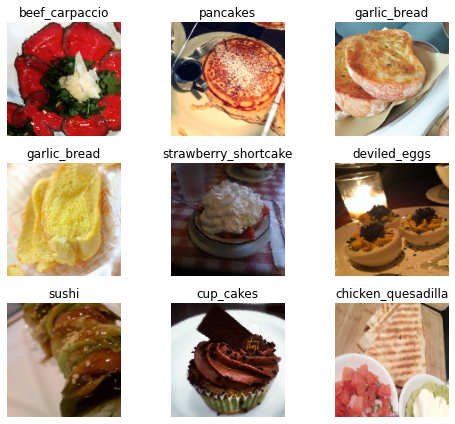

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

## Creating and training the two stage model

Downloading a pretrained RESNET34 model from torchvision library. First model is trained on the downscaled images. During this stage, only parameters in the last layer are modified first, then all of the parametrs of the model are allowed to be modified to fine-tune it.

This process is repeated for the images of larger size and the parameters of the model are saved.

In [ ]:
model = cnn_learner(data=data,base_arch= models.resnet34,pretrained=True, metrics=error_rate) #Downloading the model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


Finding the optimal learning rate by training the model on mini-batches with increasing learning rate until the loss diverges, then choosing the one that is close to the minimum loss, but far from divergence.

In [ ]:
model.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


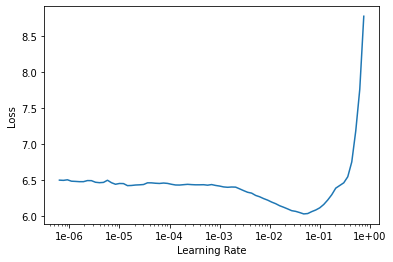

In [ ]:
model.recorder.plot()

In [ ]:
model.fit_one_cycle(5,max_lr=3e-03)

epoch,train_loss,valid_loss,error_rate,time
0,2.797012,2.218997,0.558845,14:56
1,2.394264,1.983097,0.506502,14:37
2,2.176156,1.766471,0.453630,14:31
3,2.015224,1.622194,0.419043,14:11
4,1.900144,1.586394,0.409538,14:02


Unfreezing the model to fine-tune all of the parameters before changing the size of the images

In [ ]:
model.save(base_dir + 'model_freeze_s128')

In [ ]:
model.unfreeze()

Repeating the process of finding the optimal learning rate

In [ ]:
model.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


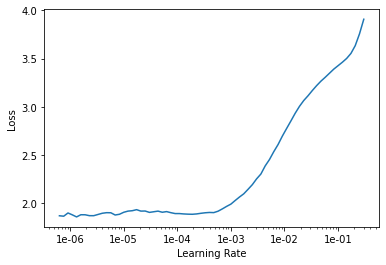

In [ ]:
model.recorder.plot()

In [ ]:
model.fit_one_cycle(5,max_lr=3e-05)

epoch,train_loss,valid_loss,error_rate,time
0,1.797309,1.537450,0.397096,14:18
1,1.735495,1.420326,0.370957,14:22
2,1.541089,1.332472,0.350693,14:17
3,1.479591,1.277176,0.335050,14:16
4,1.460565,1.267768,0.333267,14:12


Saving the parameters of the model to make it easier to make changes in later stages of the training.

Switching to the larger images for future training of the model.

In [ ]:
model.save(base_dir + 'model_unfreeze_s128_2')

In [ ]:
model.load(base_dir + 'model_unfreeze_s128_2')

In [ ]:
data = ImageList.from_folder(path=path/'images').split_by_rand_pct(valid_pct= 0.3, seed=7).label_from_folder().transform(tmfs,size=256).databunch(bs=64).normalize(imagenet_stats)

In [ ]:
model.freeze()

In [ ]:
model.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


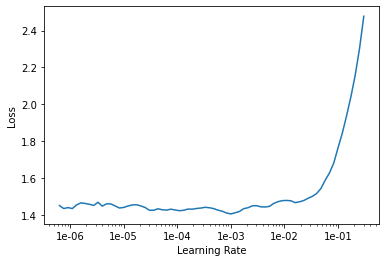

In [ ]:
model.recorder.plot()

In [ ]:
model.fit_one_cycle(7, max_lr=4e-04)

epoch,train_loss,valid_loss,error_rate,time
0,1.434567,1.262855,0.332541,14:01
1,1.434719,1.253555,0.332673,14:08
2,1.403514,1.242590,0.328944,14:13
3,1.401326,1.236887,0.328581,14:01
4,1.403150,1.228543,0.325347,14:09
5,1.401538,1.224647,0.325281,14:08
6,1.351321,1.226314,0.325512,14:10


In [ ]:
model.save(base_dir + 'model_freeze_s256')

In [ ]:
model.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


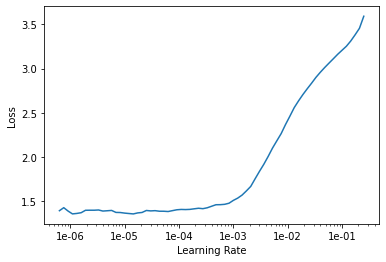

In [ ]:
model.recorder.plot()

In [ ]:
model.fit_one_cycle(5,max_lr=3e-05)

epoch,train_loss,valid_loss,error_rate,time
0,1.409496,1.247529,0.329043,14:18
1,1.454582,1.231397,0.323564,14:11
2,1.344983,1.181006,0.313267,14:15
3,1.258226,1.148440,0.305743,14:11
4,1.160788,1.143261,0.305446,14:11


In [ ]:
model.save(base_dir + 'model_unfreeze_s256')

In [ ]:
model.load(base_dir + 'model_unfreeze_s256')

In [ ]:
model.unfreeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


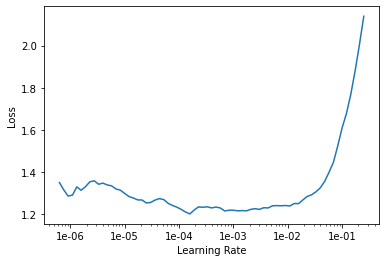

In [ ]:
model.lr_find()
model.recorder.plot()

In [ ]:
model.fit_one_cycle(5,max_lr=6e-05)

epoch,train_loss,valid_loss,error_rate,time
0,1.257669,0.885152,0.237129,14:48
1,1.299739,0.884407,0.238581,14:51
2,1.267692,0.889897,0.239406,14:47
3,1.250766,0.885821,0.238086,14:51
4,1.248490,0.885112,0.237459,14:45


In [ ]:
model.save(base_dir + 'model_final_resize')

Plotting the loss of the model against the amount of images it trained on. Initially loss was decreasing quickly and later it started to plateau, meaning that the loss function is close to its minimum and the model is close to the best accuracy. Training was stopped at this point to avoid overfitting to training data.

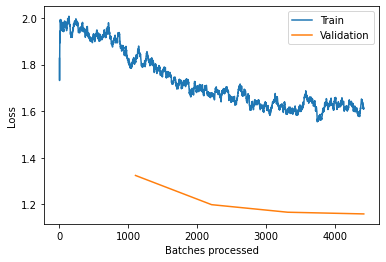

In [ ]:
model.recorder.plot_losses()

## Creating and training second model in the same way, but only with 256 image size



Creating an identical model and dataset to train on images of size 256 only and training it with the same amount of epochs.


In [ ]:
data = ImageList.from_folder(path=path/'images').split_by_rand_pct(valid_pct= 0.3, seed=7).label_from_folder().transform(tmfs,size=256).databunch(bs=32).normalize(imagenet_stats)

In [ ]:
new_model = cnn_learner(data, base_arch= models.resnet34,  pretrained=True, metrics=error_rate)

In [ ]:
new_model.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


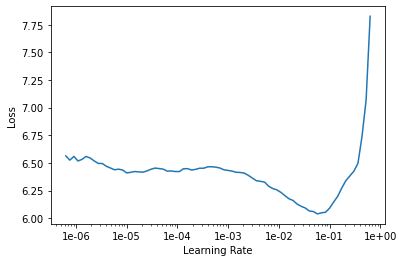

In [ ]:
new_model.recorder.plot()

In [ ]:
new_model.fit_one_cycle(5, max_lr= 7e-03)

epoch,train_loss,valid_loss,error_rate,time
0,2.811887,2.441359,0.608680,15:04
1,2.485776,2.247680,0.565479,15:03
2,2.235527,1.872404,0.478647,14:38
3,2.019316,1.662197,0.427327,14:40
4,1.910750,1.603701,0.415049,14:33


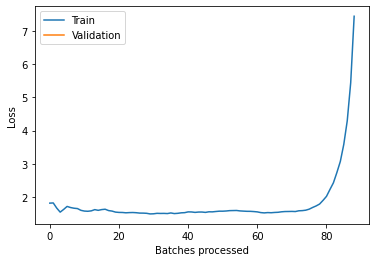

In [ ]:
new_model.recorder.plot_losses()

In [ ]:
new_model.save(base_dir + 'no_resize_5ep')

In [ ]:
new_model.load(base_dir + 'no_resize_5ep')

In [ ]:
model.unfreeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


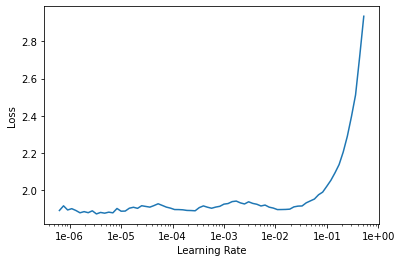

In [ ]:
new_model.lr_find()
new_model.recorder.plot()

In [ ]:
new_model.fit_one_cycle(5,max_lr=4e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.499813,1.138268,0.300165,21:20
1,1.455440,1.084158,0.285017,20:31


epoch,train_loss,valid_loss,error_rate,time
0,1.499813,1.138268,0.300165,21:20
1,1.455440,1.084158,0.285017,20:31
2,1.361731,1.041179,0.274059,21:32
3,1.326203,1.018300,0.270033,20:19
4,1.392047,1.012772,0.266964,20:18


In [ ]:
new_model.save(base_dir + 'no_resize_10ep')

In [ ]:
new_model.load(base_dir + 'no_resize_10ep')

Freezing model again to simulate the two stage training


In [ ]:
new_model.freeze()

In [ ]:
new_model.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


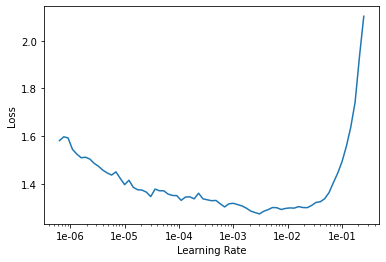

In [ ]:
new_model.recorder.plot()

In [ ]:
new_model.fit_one_cycle(7,max_lr=3e-04)

epoch,train_loss,valid_loss,error_rate,time
0,1.277151,1.011455,0.267822,20:07
1,1.324879,1.000396,0.264818,20:01
2,1.283202,0.987008,0.261221,19:41
3,1.341299,0.983700,0.260957,19:18
4,1.270532,0.978258,0.259109,18:59
5,1.232166,0.976094,0.259604,18:56
6,1.213635,0.974478,0.259010,18:55


As expected after first 17 epochs, model trained on larger images only is doing better, however the improvements are marginal at this point compared to the two stage model, which was still decreasing the loss at much faster rate and reaching better accuracy.

In [ ]:
new_model.save(base_dir + 'model_no_resize_final')

In [ ]:
new_model.load(base_dir + 'model_no_resize_final')

## Comparing the models

To compare the effectivness models, a simple comparison of the most confused categories was used. This was done using a function build in the fastai library ClassificationInterpretation.

In [ ]:
interp = ClassificationInterpretation.from_learner(model)

In [ ]:
interp_2 = ClassificationInterpretation.from_learner(new_model)

Looking at the categories which models confused at least 25 times, we can see that the two stage training model is doing slightly better at recognising different food categories. Both models had most difficulties with recognising different kinds of meats, which was expected as they look similar. However, the two stage model has less categories above the threshold. Also, looking back at the training data, both validation set loss and error rate was lower for the two stage model, making it more effective.

Two stage model most confused categories.

In [ ]:
interp.most_confused(min_val=25)

[('filet_mignon', 'steak', 38),
 ('steak', 'filet_mignon', 34),
 ('chocolate_cake', 'chocolate_mousse', 30),
 ('apple_pie', 'bread_pudding', 29),
 ('beef_tartare', 'tuna_tartare', 28),
 ('ice_cream', 'frozen_yogurt', 26),
 ('pork_chop', 'grilled_salmon', 26),
 ('sashimi', 'sushi', 25),
 ('steak', 'prime_rib', 25)]

Single stage model most confused categories.

In [ ]:
interp_2.most_confused(min_val=25)

[('filet_mignon', 'steak', 45),
 ('ice_cream', 'frozen_yogurt', 32),
 ('steak', 'filet_mignon', 32),
 ('chocolate_cake', 'chocolate_mousse', 31),
 ('apple_pie', 'bread_pudding', 27),
 ('pork_chop', 'grilled_salmon', 26),
 ('tuna_tartare', 'beef_tartare', 26),
 ('beef_tartare', 'tuna_tartare', 25),
 ('filet_mignon', 'pork_chop', 25),
 ('steak', 'prime_rib', 25)]

Two stage model highest loss pictures

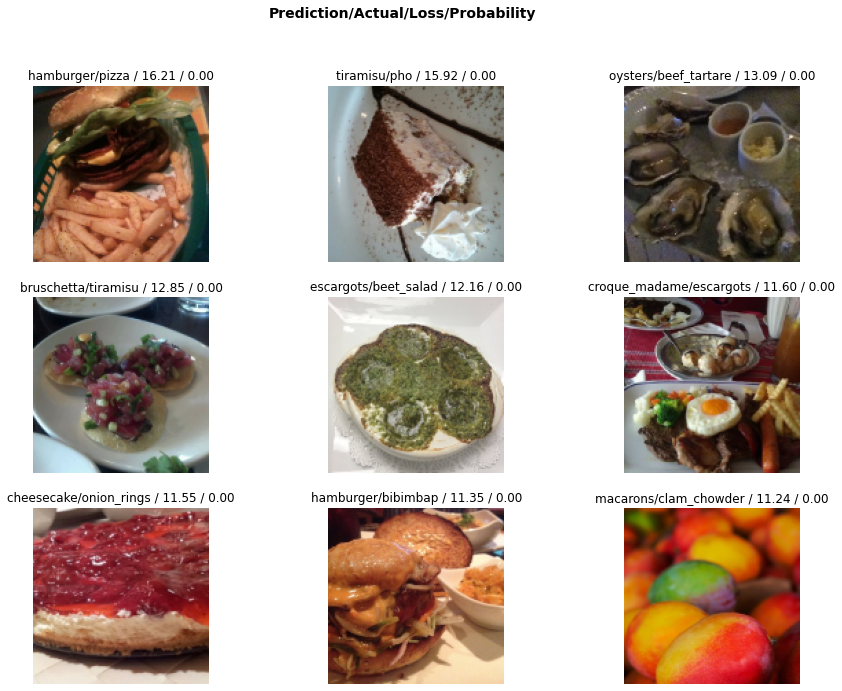

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

Single stage model highest loss pictures

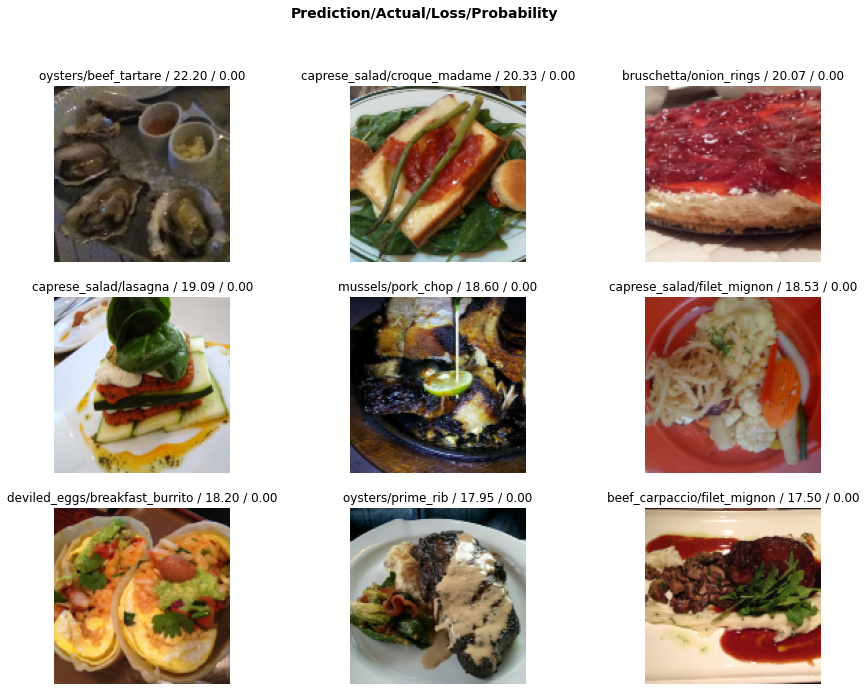

In [ ]:
interp_2.plot_top_losses(9, figsize=(15,11))